## Photometric galaxy redshift determination using an Ensemble of Regressors

_version 1 20/3/2018_

_version 1.1 28/5/2024_ : add LGBM regressor, compatibility with Python > 3.0

_Wing-Fai Thi_

The ensemble includes k-Nearest Neighbors, XGBoost, Support Vector Machine, lightGBM,
and an Orthogonal Distance Regression method based on ODRpack, which can
account in the fit the errors for the predictor values.

The meta prediction is the weighted sum of the different predictions, where
the weights are inversely proportional to the root-mean-square.

The expansion of the Universe makes that objects farther away from us are receding, 
resulting in a Doppler shift of their electromagnetic emission towards lower 
frequencies (hence redshift). [wikipedia](https://en.wikipedia.org/wiki/Redshift)

Obtaining spectroscopic redshifts is a time-consuming endeavor compared to photometric
redshifts, except that spectroscopic redshifts are much more precised and accurate.
The challenge is to find the most precise and accurate photometric redshift
determinations.

The data is described in Section 1.5.5 of Ref 1. The training set consists
of u, g , r, i, z magnitudes and their associated erros of 60,000 galaxies
from the SDSS spectroscopic sample from a total of ~600,000 galaxies.

Validation is performed on an additional 6000 galaxies. The left panel
shows prediction error as a function of the spectroscopic redshift
computed by Monte-Carlo simulation.

### Aim of the notebook

Apply different regressors and obtain the best possible estimations of the redshifts.

### Reference

1. "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)

2. Analysis of a custom support vector machine for photometric redshift estimation and the
    inclusion of galaxy shape information
    E. Jones and J. Singal A&A 600, A113 (2017) [preprint](https://arxiv.org/abs/1607.00044)

3. [Sloan Digital Sky Survey](http://www.sdss.org)

4. Baysian approach photometric redshift determination by Nacisco Benitez [(ApJ paper)](http://iopscience.iop.org/article/10.1086/308947/pdf)

4. PHAT: PHoto-z Accuracy Testing a benchmark of different estimation methods. See the paper by [Hildebrandt et al.](https://www.aanda.org/articles/aa/pdf/2010/15/aa14885-10.pdf)

5. [XGBoost package](https://github.com/dmlc/xgboost) and the reference [paper](https://www.aanda.org/articles/aa/pdf/2010/15/aa14885-10.pdf)

The notebook is based on a Python script by Jake VanderPlas. For more information on the original code, see http://astroML.github.com.  The original script has another definition of
the rms.

In addition to the standard packages for data science (mumpy, matplotlib, sklearn), the notebook requires two additional packages (xgboost and astroML) as well as the ODLinear routines found on this website. The additional packages can be easily donwloaded (I use sudo pip install name_of_the_package) on a Mac.

In [1]:
import numpy as np
import os # use for file reading/writing
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import lightgbm as lgbm
from xgboost.sklearn import XGBRegressor # use the XGBoost routine
from ODLinear import OrthogonalDistanceLinearRegression

from astroML.datasets import fetch_sdss_specgals # routine to fetch the data from the web
import pickle

# get configuration current settings
#print (mpl.rcParams)

# Change the default settings
mpl.rcParams.update({'figure.figsize': (9.0, 7.0),
                     'figure.dpi' : 300, # 300 dpi for print
                    'font.size': 14,
                     'legend.frameon': False,              
                     'legend.fontsize' : 12, 
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'axes.labelsize'  : 18  
                    })

In [2]:
#------------------------------------------------------------
# Fetch the data if it is not locally downloaded and prepare it for the computation
# I have it on a specific directory
#data = fetch_sdss_specgals()  
data = fetch_sdss_specgals("./")

We select only a fraction of the total available dataset and we remove a couple of outliers.

In [3]:
# put magnitudes in a matrix
mag     = np.vstack([data['modelMag_%s' % f] for f in 'ugriz']).T
mag_err = np.vstack([data['modelMagErr_%s' % f] for f in 'ugriz']).T

# train/test on 10% of ~ 661 598 points
mag     = mag[::10]
mag_err = mag_err[::10]
z = data['z']
z = z[::10]

w = ((mag[:,1] < 20.) & (mag[:,2] < 18.5) & (mag[:,3] < 18.5) & (mag[:,4] < 18.5))
print("total number of objects:",mag.shape[0])
print("number of objects retained:",mag[w].shape[0])
mag = mag[w]
z   = z[w]

total number of objects: 66160
number of objects retained: 66091


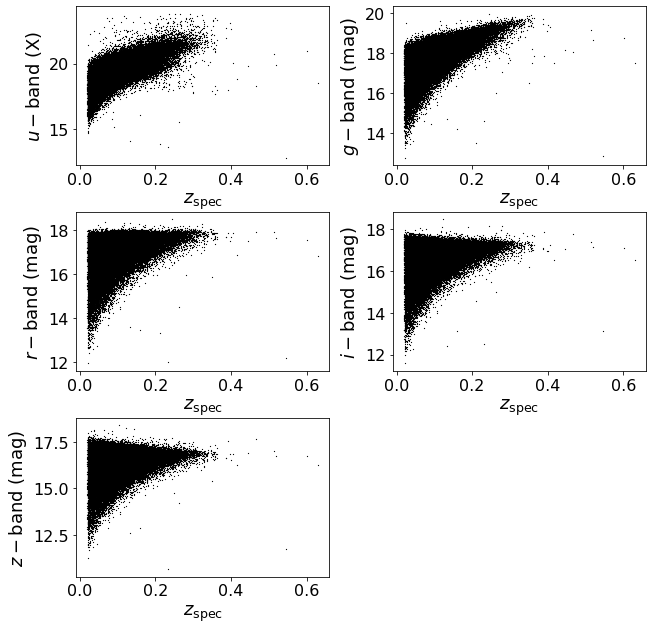

In [4]:
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(wspace=0.25,hspace=0.3,
                    left=0.07, right=0.95,
                    bottom=0.07, top=0.95)

# u, g , r, i, z magnitudes
ax1 = fig.add_subplot(321)
ax1.scatter(z,mag[:,0],s=1.5, lw=0, c='k')
ax1.set_xlabel(r'$z_{\rm spec}$')
ax1.set_ylabel(r'$u-{\rm band\ (X)}$')

ax1 = fig.add_subplot(322)
ax1.scatter(z,mag[:,1],s=1.5, lw=0, c='k')
ax1.set_xlabel(r'$z_{\rm spec}$')
ax1.set_ylabel(r'$g-{\rm band\ (mag)}$')

ax1 = fig.add_subplot(323)
ax1.scatter(z,mag[:,2],s=1.5, lw=0, c='k')
ax1.set_xlabel(r'$z_{\rm spec}$')
ax1.set_ylabel(r'$r-{\rm band\ (mag)}$')

ax1 = fig.add_subplot(324)
ax1.scatter(z,mag[:,3],s=1.5, lw=0, c='k')
ax1.set_xlabel(r'$z_{\rm spec}$')
ax1.set_ylabel(r'$i-{\rm band\ (mag)}$')

ax1 = fig.add_subplot(325)
ax1.scatter(z,mag[:,4],s=1.5, lw=0, c='k')
ax1.set_xlabel(r'$z_{\rm spec}$')
ax1.set_ylabel(r'$z-{\rm band\ (mag)}$')
fig.savefig('fig_photoz_magnitudes.png')
plt.show()

The astronomical data are in magnitude scale, ie mag - mag_ref = -2.5 log10 (Flux/Flux_ref),
where mag_ref and Flux_ref are the reference magnitude for a given reference flux. The primary
flux reference is the star Vega, whose magnitudes are set to zero. 

We can see the magnitude distribution in a flux (magnitude)-limited sky survey. As the flux decreases as 1/distance squared, the bright galaxies light are dimmed at high distances (ie at high redshifts). The faint galaxies high-redshift equivalent to the nearby galaxies cannot be detected.

We now create colors = magnitude(band 1) - magnitude(band 2). Notice that the Sloan survey did use unconventional photometric bands.

In [5]:
# from the mangitudes u, g , r, i, z create the colors (u-g) (g-r) (r-i) (i-z)
col = np.empty(mag.shape)
col[:,0] = mag[:,0] - mag[:,1]
col[:,1] = mag[:,1] - mag[:,2]
col[:,2] = mag[:,2] - mag[:,3]
col[:,3] = mag[:,3] - mag[:,4]
col[:,4] = mag[:,0]

col_err = np.empty(mag_err.shape)
col_err[:,0] = np.sqrt(mag_err[:,0]**2 + mag_err[:,1]**2)  # sig(1-2)= sqrt(sig1^1+sig2^2)
col_err[:,1] = np.sqrt(mag_err[:,1]**2 + mag_err[:,2]**2)
col_err[:,2] = np.sqrt(mag_err[:,2]**2 + mag_err[:,3]**2)
col_err[:,3] = np.sqrt(mag_err[:,3]**2 + mag_err[:,4]**2)
col_err[:,4] = mag_err[:,0]

Plot the colors.

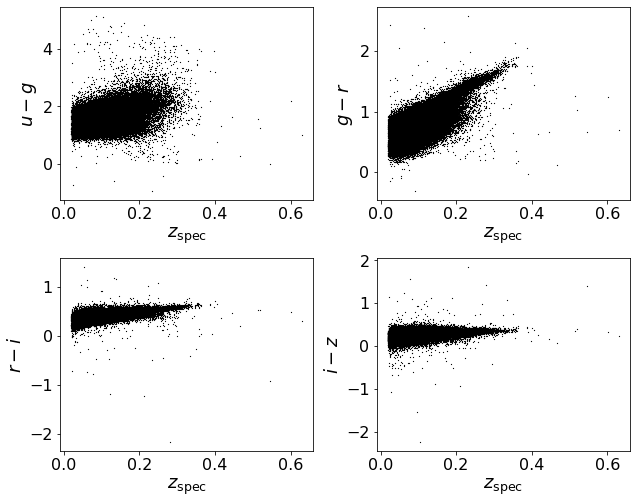

In [6]:
# plot the colors u-g, g-r , r-i, i-z
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(wspace=0.25, hspace=0.3,
                    left=0.07, right=0.95,
                    bottom=0.07, top=0.95)
ax2 = fig.add_subplot(221)
ax2.scatter(z,col[:,0],s=1.5, lw=0, c='k')
ax2.set_xlabel(r'$z_{\rm spec}$')
ax2.set_ylabel(r'$u-g$')

ax2 = fig.add_subplot(222)
ax2.scatter(z,col[:,1],s=1.5, lw=0, c='k')
ax2.set_xlabel(r'$z_{\rm spec}$')
ax2.set_ylabel(r'$g-r$')

ax2 = fig.add_subplot(223)
ax2.scatter(z,col[:,2],s=1.5, lw=0, c='k')
ax2.set_xlabel(r'$z_{\rm spec}$')
ax2.set_ylabel(r'$r-i$')

ax2 = fig.add_subplot(224)
ax2.scatter(z,col[:,3],s=1.5, lw=0, c='k')
ax2.set_xlabel(r'$z_{\rm spec}$')
ax2.set_ylabel(r'$i-z$')
fig.savefig('fig_photoz_colors.png')
plt.show()

We split the datasset into the trainning and test dataset. One can choose between trainning on the magnitudes or on the colors. The magnitudes (and colors) have measurement uncertainties.

In [7]:
# splitting into 80%/20% train/test dataset
ind = np.arange(z.size)
ind_train, ind_test, z_train, z_test = train_test_split(ind, z, 
                                                        test_size=0.2, random_state=2018)

if(True): # if True train on the colors
    print("Train on the colors")
    X_train = col[ind_train]
    X_test  = col[ind_test]
    X_train_err = col_err[ind_train]
    X_test_err  = col_err[ind_test]
else:
    print("Train on the magnitudes")
    X_train = mag[ind_train]
    X_test  = mag[ind_test]
    X_train_err = mag_err[ind_train]
    X_test_err  = mag_err[ind_test]

Train on the colors


We create here a dictionary with several regressors. One can modify the list to test your favorite routines.
- Extrem Gradient Boosting (XGBoost): a boosted Random Forest
- K Neighbors Regressor (KNN)
- Multi-layer Perceptron Neural Network (NN)
- Orthogonal Distance Linear Regression (ODLR) with 2nd degree polynomial features
- Non-linear Support Vector Machine Regressor (SVM), with RBF kernel
- LightGBM

In [22]:
#------------------------------------------------------------
# Compute the scores for several regressors

lgb_params = {'verbosity': -1, 'n_estimators': 500, 'learning_rate': 0.02,
              'num_leaves': 250, 'max_depth': 10, 'random_state': 0, }

regressors = {'XGBoost': XGBRegressor(n_estimators=200, early_stopping_rounds=10,
                                      max_depth=5, objective='reg:squarederror',
                                      seed=2001, learning_rate=0.1),
                'KNN': KNeighborsRegressor(15,weights='uniform'),
                'NN' : MLPRegressor(solver='adam',
                                    hidden_layer_sizes=(100,150,100), early_stopping=True),
                'ODLR':OrthogonalDistanceLinearRegression(tol=1e-8, C=50),
                'SVM': SVR(kernel='rbf', C=1e3, gamma=0.1),
                'LGBM': lgbm.LGBMRegressor(**lgb_params)
             }

# Create polynomial features for the linear regressor ODLR
poly = PolynomialFeatures(degree=2,include_bias=False)
poly.fit(X_train)
X_poly_train = poly.transform(X_train)
X_poly_test  = poly.transform(X_test)
X_poly_train_err = poly.transform(X_train_err)
X_poly_test_err  = poly.transform(X_test_err)

In [24]:
regressors

{'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'KNN': KNeighborsRegressor(n_neighbors=15),
 'NN': MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 150, 100)),
 'ODLR': <ODLinear.OrthogonalDistanceLinearRegression at 0x137f3c250>,
 'SVM': SVR(C=1000.0, gamma=0.1),
 'LGBM': 

In order of avoid training, one can used saved models. We use the joblib package from sklearn.

In [25]:
filename = 'photoz_ensemble.sav'
regs  = []
if os.path.exists(filename): # read previously run models using joblib from sklearn
    print("Read previously ran models")
    with open(filename, 'rb') as file:
        regs = pickle.load(file)
    file.close()

Run (train, predict) and save the regression models.

In [26]:
names = []
test_preds = []
test_pred_errors = []
train_pred_errors = []
train_preds = []
train_scores = []
test_scores = []

for i, (name,regressor) in enumerate(regressors.items()):
    print("Regressor ",name)
    if not (os.path.exists(filename)):
        model = regressor
        if(name == "ODLR"):
            model.fit(X_poly_train, z_train, X_err = X_poly_train_err)
        elif(name == "XGBoost"):
            model.fit(X_train, z_train,
                      eval_set=[(X_test, z_test)], verbose=False)
        elif(name == "LGBM"):
            model.fit(X_train, z_train,
                      eval_set=[(X_test, z_test)],
                      callbacks=[lgbm.early_stopping(stopping_rounds=10),
                                 lgbm.log_evaluation(100)])
        else:
            model.fit(X_train, z_train)
    else:
        model = regs[i]
    # make predictions
    if(name == "ODLR"):
        y_pred = model.predict(X_poly_test)
        train_pred = model.predict(X_poly_train)
        test_pred_errors.append(model.predict_MC_error(X_poly_test, 
                                                       X_err=X_poly_test_err, 
                                                       Number_of_MC_iterations=100))
        train_pred_errors.append(model.predict_MC_error(X_poly_train, 
                                                        X_err=X_poly_train_err, 
                                                        Number_of_MC_iterations=100))
        train_score  = model.score(X_poly_train, z_train)
        test_score  = model.score(X_poly_test, z_test)
    else:
        y_pred = model.predict(X_test)
        train_pred = model.predict(X_train)
        train_score  = model.score(X_train, z_train)
        test_score  = model.score(X_test, z_test)
    test_preds.append(y_pred)
    train_preds.append(train_pred)
    names.append(name)
    regs.append(model)
    train_scores.append(train_score)
    test_scores.append(test_score)

# Save the model to disk
if not(os.path.exists(filename)):
    print("Saving models")
    with open(filename, 'wb') as file:
        pickle.dump(regs, file)
    file.close()

Regressor  XGBoost
Regressor  KNN
Regressor  NN
Regressor  ODLR
Regressor  SVM
Regressor  LGBM
Training until validation scores don't improve for 10 rounds
[100]	valid_0's l2: 0.000532924
[200]	valid_0's l2: 0.000475852
[300]	valid_0's l2: 0.000473024
Early stopping, best iteration is:
[377]	valid_0's l2: 0.00047224
Saving models


ODLR has a method to compute errors propgation from the observational uncertainties.

Here are the results from the training. Notice that special definition of rms used here (see Jones and Singal 2017)

In [28]:
rms = []
print("Test score")
for (name,regressor),score,z_pred in zip(regressors.items(),test_scores,test_preds):
    rms_regressor = np.sqrt((((z_pred-z_test)/(1+z_test))**2).sum()/z_test.size)
    print(name,(" - score: %1.3f" % score),(" - rms: %1.3f" % rms_regressor))
    rms.append(rms_regressor)
rms = np.array(rms)

Test score
XGBoost  - score: 0.837  - rms: 0.019
KNN  - score: 0.823  - rms: 0.020
NN  - score: 0.802  - rms: 0.021
ODLR  - score: 0.750  - rms: 0.023
SVM  - score: 0.500  - rms: 0.035
LGBM  - score: 0.836  - rms: 0.019


Measurement errors can affect the prediction values. One simple way to estimate the error on the predictions is
to perfom Monte-Carlo simulations.

In [29]:
# Number_of_MC_iterations is the number of Monte-Carlo simulations
def predict_MC_error(X, X_err, Number_of_MC_iterations=1000):
    pred_MC=[]
    for i in range(Number_of_MC_iterations) :
        X_MC = np.random.normal(X, X_err)       # generate a random input 
        pred_MC.append(regressor.predict(X_MC)) # regressor is your regressor class instance
    pred_MC = np.array(pred_MC)
    std_pred = np.std(pred_MC,axis=0)
    return std_pred  

In [30]:
regressor = regs[0]

In [31]:
XGBoost_test_pred_errors = predict_MC_error(X_train ,X_train_err, Number_of_MC_iterations=100)
print("XGBoost prediction error propagation: %1.3f" %XGBoost_test_pred_errors.mean())

XGBoost prediction error propagation: 0.009


In [32]:
# prediction errors based on Monte-Carlo simulation of galaxies with errors in magnitudes
# based on ODLR only
test_pred_errors = np.array(test_pred_errors).reshape(z_test.size)
train_pred_errors = np.array(train_pred_errors).reshape(z_train.size)
test_preds = np.array(test_preds).T
train_preds = np.array(train_preds).T

The meta model (Ensemble) is simply the weighted mean between the different model predictions, with weight = 1 / rms

In [33]:
print('Ensemble model is the mean of', train_preds.shape[1], 'models')

Ensemble model is the mean of 6 models


In [34]:
# the ensemble photometric redshift is just the mean between the methods
# weighted mean with weight=1/rms
z_train_meta = (train_preds.dot(1. / rms)) / (1. / rms).sum()
z_test_meta  = (test_preds.dot(1. / rms)) / (1. / rms).sum()
rms_train_meta = np.sqrt((((z_train_meta - z_train) / (1+z_train))**2).sum() / z_train.size)
rms_meta       = np.sqrt((((z_test_meta - z_test)  / (1+z_test))**2).sum() / z_test.size)
print("meta train rms: %1.3f" % rms_train_meta)
print("meta test rms: %1.3f" % rms_meta)

meta train rms: 0.019
meta test rms: 0.020


Find the outliers in the predictions. The definition can be found in Jones and Singal (2017).

In [35]:
# Outliers
woutliers_train = (abs(z_train_meta - z_train) / (1 + z_train) > 0.15)
woutliers_test = (abs(z_test_meta - z_test) / (1 + z_test) > 0.15)

Results for the training set. The outliers are shown in red inthe lower-right panel.

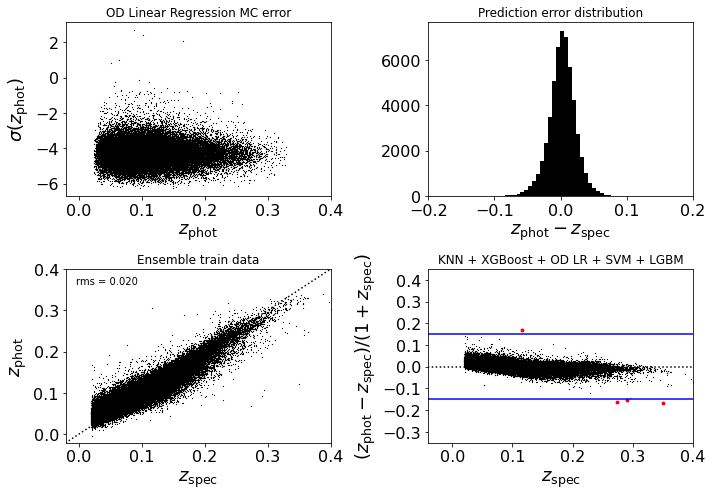

In [38]:
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(wspace=0.4, hspace=0.35,
                    left=0.07, right=0.95,
                    bottom=0.07, top=0.95)
#
ax3 = fig.add_subplot(221)
j = np.argsort(z_train)
ax3.scatter(train_preds[:,1], np.log(train_pred_errors[j]), s=1.5, lw=0, c='k')
ax3.set_title("OD Linear Regression MC error")
ax3.set_ylabel(r'$\sigma(z_{\rm phot})$')
ax3.set_xlabel(r'$z_{\rm phot}$')
ax3.set_xlim(-0.02, 0.4001)
#
ax3 = fig.add_subplot(222)
ax3.hist(z_train_meta - z_train, color='black', bins=100)
ax3.set_title("Prediction error distribution")
ax3.set_xlabel(r'$z_{\rm phot}-z_{\rm spec}$')
ax3.set_xlim(-0.2001, 0.2001)

#
ax3 = fig.add_subplot(223)
ax3.scatter(z_train, z_train_meta, s=1.5, lw=0, c='k')
ax3.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax3.text(0.04, 0.96, "rms = %.3f" % (rms_meta),
        ha='left', va='top', transform=ax3.transAxes)

ax3.set_ylabel(r'$z_{\rm phot}$')
ax3.set_xlabel(r'$z_{\rm spec}$')

ax3.set_title("Ensemble train data")
ax3.set_xlim(-0.02, 0.4001)
ax3.set_ylim(-0.02, 0.4001)
ax3.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax3 = fig.add_subplot(224)
ax3.scatter(z_train, (z_train_meta-z_train)/(1+z_train), s=1.5, lw=0, c='k')
z_train_outliers = z_train[woutliers_train]
z_train_meta_outliers = z_train_meta[woutliers_train]
ax3.scatter(z_train_outliers,
            (z_train_meta_outliers-z_train_outliers)/(1+z_train_outliers), s=15, lw=0, c='red')

ax3.plot([-0.1, 0.4], [0.0, 0.0], ':k')
ax3.plot([-0.1, 0.4],[-0.15,-0.15], color='blue')
ax3.plot([-0.1, 0.4],[0.15,0.15], color='blue')

ax3.set_xlabel(r'$z_{\rm spec}$')
ax3.set_ylabel(r'$(z_{\rm phot}-z_{\rm spec})/(1+z_{\rm spec})$')

ax3.set_xlim(-0.04, 0.4001)
ax3.set_ylim(-0.3501, 0.4501)
ax3.set_title("KNN + XGBoost + OD LR + SVM + LGBM")
ax3.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.1))
plt.tight_layout()
fig.savefig('fig_photoz_Ensemble_train.png')


The results for the test set.

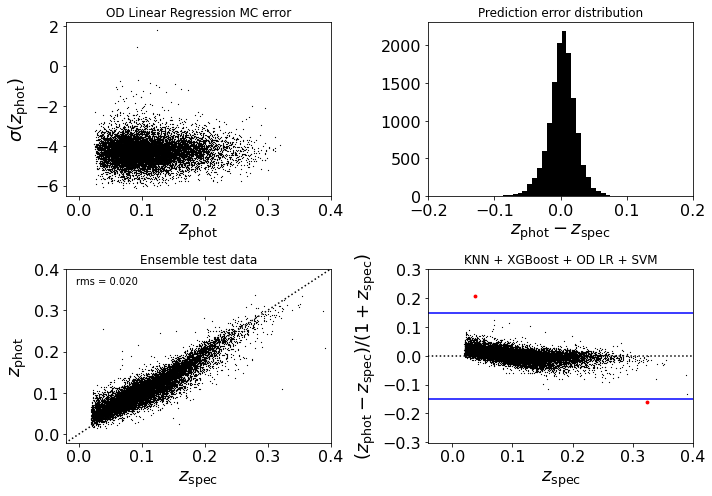

In [39]:
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(wspace=0.4,hspace=0.35,
                    left=0.07, right=0.95,
                    bottom=0.07, top=0.95)
#
ax4 = fig.add_subplot(221)
j = np.argsort(z_test)
ax4.scatter(test_preds[:,1],np.log(test_pred_errors[j]),s=1.5, lw=0, c='k')
ax4.set_title("OD Linear Regression MC error")
ax4.set_ylabel(r'$\sigma(z_{\rm phot})$')
ax4.set_xlabel(r'$z_{\rm phot}$')
ax4.set_xlim(-0.02, 0.4001)
#
ax4 = fig.add_subplot(222)
ax4.hist(z_test_meta-z_test, color='black', bins=100)
ax4.set_title("Prediction error distribution")
ax4.set_xlabel(r'$z_{\rm phot}-z_{\rm spec}$')
ax4.set_xlim(-0.2001, 0.2001)

#
ax4 = fig.add_subplot(223)
ax4.scatter(z_test, z_test_meta, s=1.5, lw=0, c='k')
ax4.plot([-0.1, 0.4], [-0.1, 0.4], ':k')
ax4.text(0.04, 0.96, "rms = %.3f" % (rms_meta),
         ha='left', va='top', transform=ax4.transAxes)

ax4.set_ylabel(r'$z_{\rm phot}$')
ax4.set_xlabel(r'$z_{\rm spec}$')

ax4.set_title("Ensemble test data")
ax4.set_xlim(-0.02, 0.4001)
ax4.set_ylim(-0.02, 0.4001)
ax4.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax4.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax4 = fig.add_subplot(224)
ax4.scatter(z_test, (z_test_meta-z_test)/(1+z_test), s=1.5, lw=0, c='k')
z_test_outliers = z_test[woutliers_test]
z_test_meta_outliers = z_test_meta[woutliers_test]
ax4.scatter(z_test_outliers,
            (z_test_meta_outliers-z_test_outliers)/(1+z_test_outliers), s=15, lw=0, c='red')

ax4.plot([-0.1, 0.4], [0.0, 0.0], ':k')
ax4.plot([-0.1, 0.4],[-0.15,-0.15], color='blue')
ax4.plot([-0.1, 0.4],[0.15,0.15], color='blue')

ax4.set_xlabel(r'$z_{\rm spec}$')
ax4.set_ylabel(r'$(z_{\rm phot}-z_{\rm spec})/(1+z_{\rm spec})$')

ax4.set_xlim(-0.04, 0.4001)
ax4.set_ylim(-0.301, 0.301)
ax4.set_title("KNN + XGBoost + OD LR + SVM")
ax4.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax4.yaxis.set_major_locator(plt.MultipleLocator(0.1))
plt.tight_layout()
fig.savefig('fig_photoz_Ensemble_test.png')

plt.show()

The ensemble of regressors manage a rms of 0.02 for both the training an the test datasets.
The error due to the uncertainties in the magnitudes is much lower than the regression error (see upper-left panels). The prediction error distribution error is normal. One can see that the errors are positives for redshifts < 0.1. It does not make sense to have negative redshifts.

We employed a few of the most efficient regressors avaialble. The best-performing regressor is XGBoost ang LGBM (which is not surprising). The spread in errors is quite uniform as function of redshift. A scientist would prefer that the error being proportional to its value.

### Summary
In this notebook, we learn:
- how to change Matplotlib default settings
- how to use an ensemble of regressors
- a way to estimate the errors on the predictions due to measurement errors
- how to save and read machine learning models (sklearn.externals.joblib)
- simple astrononimal concepts like magnitude, color, adn redshift